In [1]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import streaminghub_pydfds as dfds
from tqdm import tqdm

pd.set_option('display.max_rows', int(1e9))
pd.set_option('display.max_columns', int(1e9))

%cd evaluation/cstdy_optimization

/Users/yasith/projects/streaminghub/evaluation/cstdy_optimization


In [2]:
cols = ["t", "x", "y"]
base_path = Path.cwd() / "generated"
print(base_path)

/Users/yasith/projects/streaminghub/evaluation/cstdy_optimization/generated


In [190]:
def compute_stat(fp: Path):

    dir_name = fp.parent.name
    file_name = fp.name

    subject, noise, task = dir_name.split("_")
    simulation, vt = file_name[:file_name.rfind('.')].split("_")

    with open(fp) as f:
        recs = [json.loads(line) for line in f.readlines()]
    rcn_df = pd.DataFrame(recs)
    rcn_df["t"] = rcn_df["t"].round(2)
    rcn_df = rcn_df[cols]
    t0, tn = rcn_df["t"].iloc[0], rcn_df["t"].iloc[-1]

    # source dataset
    src_dir = dfds.load_config().data_dir
    src_fp = src_dir / "ADHD_SIN" / f"{subject}_{noise}_{task}.parquet"
    reader = dfds.create_reader(src_fp)
    src_meta, src_df = reader.read(rec_path=".")
    src_df["x"] = (src_df["lx"] + src_df["rx"]) / 2
    src_df["y"] = (src_df["ly"] + src_df["ry"]) / 2
    src_df["t"] = ((src_df["t"] - src_df["t"].iloc[0]) * 1e-3).round(2)
    src_df = src_df[src_df["t"].between(t0, tn)][cols]

    rcn_df = rcn_df.set_index("t")
    src_df = src_df.set_index("t")
    
    m = rcn_df.join(src_df, lsuffix="_rcn", rsuffix="_src", how="inner").dropna()
    if len(m) == 0:
        return None
    m["err_l2"] = ((m["x_rcn"] - m["x_src"]) ** 2 + (m["y_rcn"] - m["y_src"]) ** 2) ** 0.5
    err_mean = m["err_l2"].mean()
    err_std = m["err_l2"].std()

    return dict(subject=subject, noise=noise, task=task, simulation=simulation, vt=vt, err_mean=err_mean, err_std=err_std)

In [191]:
stats = []
errors = []

for fp in (pbar := tqdm(sorted(base_path.glob("*/*.log")))):
    stat = compute_stat(fp)
    if stat is None:
        errors.append(fp)
    else:
        stats.append(stat)
    pbar.set_postfix_str(f"passed={len(stats)}, failed={len(errors)}")

stats_df = pd.DataFrame(stats)
stats_df.to_csv("generated/summary.csv", index=False)

100%|██████████| 7500/7500 [00:46<00:00, 162.99it/s, passed=7460, failed=40]


In [259]:
def group_and_plot(*, fp: str, gcol: str | None = None, legend: bool = False, yerr: bool = True):
    cols = ["vt", gcol] if gcol is not None else ["vt"]
    sdf = stats_df.groupby(cols).agg({"err_mean": "mean", "err_std": "mean"}).reset_index()
    # scale error bars by factor 0.02 for visualization
    sdf["err_std_vis"] = sdf["err_std"] / 50
    sdf["vt"] = sdf["vt"].astype(int)
    if gcol is not None:
        sdf[gcol] = sdf[gcol].astype(int)
    sdf = sdf.sort_values(cols).set_index("vt")
    if gcol is None:
        sdf.plot.line(
            y="err_mean",
            yerr="err_std_vis" if yerr else None,
            subplots=True,
            ylabel="MSE",
            xlabel="Velocity Threshold (VT)",
            title="MSE vs VT (Overall)",
            legend=legend,
        )
    else:
        fig, axs = plt.subplots(1, 1)
        for c in sdf[gcol].unique():
            sdf[sdf[gcol] == c].plot.line(
            y="err_mean",
            yerr="err_std_vis" if yerr else None,
            label=c,
            ylabel="MSE",
            xlabel="Velocity Threshold (VT)",
            title=f"MSE vs VT ({gcol.title()})",
            ax=axs,
            legend=legend,
        )
    plt.tight_layout()
    plt.savefig(fp)
    plt.show()

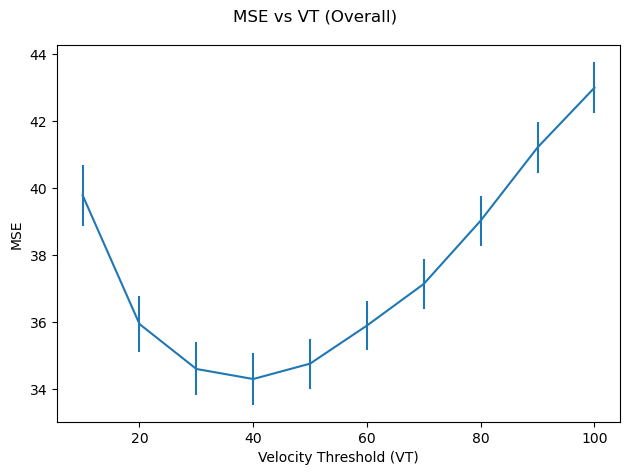

In [260]:
group_and_plot(fp="figures/hparams_overall.pdf")

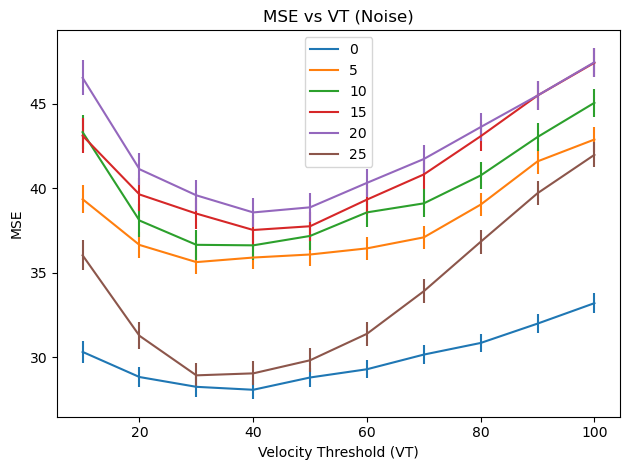

In [261]:
group_and_plot(fp="figures/hparams_noise.pdf", gcol="noise", legend=True)

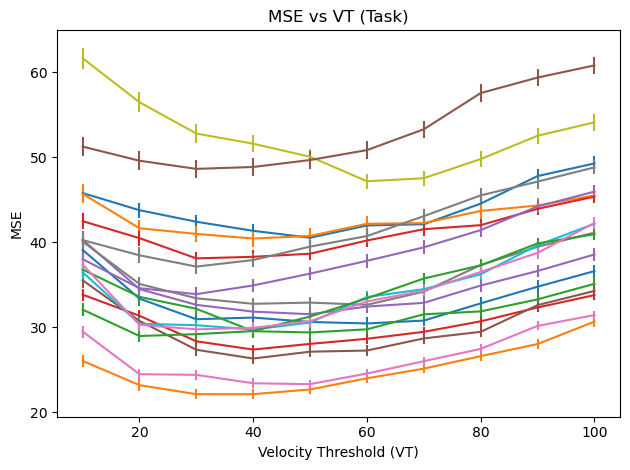

In [262]:
group_and_plot(fp="figures/hparams_task.pdf", gcol="task")

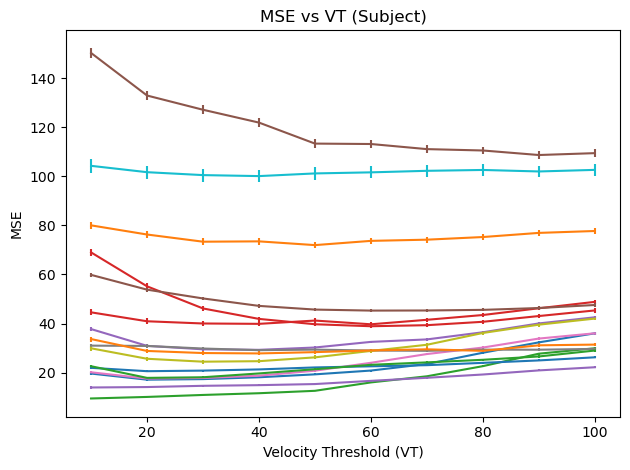

In [263]:
group_and_plot(fp="figures/hparams_subject.pdf", gcol="subject")